In [1]:
import numpy as np  # mathematical functions
import pandas as pd  # data frame manipulation
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # visualization

In [2]:
# Load the data
week_es = pd.read_excel('Weekly_Demand.xlsx',sheet_name='ES_Weekly')
week_vc = pd.read_excel('Weekly_Demand.xlsx',sheet_name='VC_Weekly')

# 1. Splitting

In [3]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets ratio 70:30
def split(df): # for other methods
    df['DATE'] = df['DATE'].view('int64') // 10**9
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['Weekly Demand']),
                                                        df['Weekly Demand'], 
                                                        train_size=0.7,
                                                        random_state=42,
                                                        shuffle=False)
    return X_train, X_test, y_train, y_test

# 2. Error measures

In [4]:
def error_measure(y,y_pred,y_pred_benchmark):
    # Median Absolute Error (MdAE)
    MdAE = np.median(np.abs(y - y_pred))
    print("MdAE:",f"{MdAE:.3f}") # Round to 3 decimal places
    
    # Mean Absolute Error (MAE)
    MAE = np.mean(np.abs(y - y_pred))
    print("MAE:",f"{MAE:.3f}") # Round to 3 decimal places
    
    # Symmetric Median Absolute Percentage Error (sMdAPE)
    sMdAPE = np.median(200 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))
    print("sMdAPE:", f"{sMdAPE:.3f}","%") # Round to 3 decimal places
    
    # Symmetric Mean Absolute Percentage Error (sMAPE)
    sMAPE = np.mean(200 * np.abs(y - y_pred) / (np.abs(y) + np.abs(y_pred)))
    print("sMAPE:", f"{sMAPE:.3f}","%") # Round to 3 decimal places
    
    # Relative Median Absolute Error (RelMdAE)
    MdAE_benchmark = np.median(np.abs(y - y_pred_benchmark))
    RelMdAE = MdAE/MdAE_benchmark
    print("RelMdAE:", f"{RelMdAE:.3f}") # Round to 3 decimal places
    
    # Relative Mean Absolute Error (RelMAE)
    MAE_benchmark = np.mean(np.abs(y - y_pred_benchmark))
    RelMAE = MAE/MAE_benchmark
    print("RelMAE:", f"{RelMAE:.3f}") # Round to 3 decimal places
    

In [5]:
def RSS(y,y_pred):
    # RSS
    RSS = np.sum((y - y_pred)**2)
    print("Residual :", f"{RSS:.3f}") # Round to 3 decimal places

In [6]:
def r_squared(y,y_pred,y_train):
    # R squares (R2)
    R2 = 1 - (np.sum((y - y_pred)**2)/np.sum((y - y_train.mean())**2))
    print("R-squared:", f"{R2:.3f}") # Round to 3 decimal places

# 3. Benchmark

In [7]:
def mean_model(y_train,y_test):
    average = y_train.mean()
    
    # Generate forecasts in training part
    y_pred_train = pd.Series(average, index=y_train.index)
    
    # Generate forecasts in testing part
    y_pred_test = pd.Series(average, index=y_test.index)
    return y_pred_train, y_pred_test

# 4. Visualization

In [8]:
def viz(y,y_pred):
    plt.figure(figsize=(15,7))
    # Create chart
    plt.plot(y.index, y, label='Actual Demand')
    plt.plot(y.index, y_pred, label='Predicted Demand')
    # Set x-axis tick locations and labels
    plt.xticks(y.index, y.index.astype(int))
    # Add baseline
    plt.axhline(y=y.mean(), color='red', linestyle='--', label='Baseline')
    plt.xlabel('Week')
    plt.ylabel('Weekly Demand')
    plt.ylim(bottom=0) # Set the starting point of the vertical axis to zero
    plt.legend()
    plt.show()

In [9]:
def viz_both(X_train,X_test,y_train,y_test,model_train,model_test):
    # Plot actual vs predicted demand in the training part
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.plot(X_train.index, y_train, label='Training Demand')
    plt.plot(X_test.index, y_test, label='Testing Demand')
    plt.plot(X_train.index, model_train, label='Training Predicts')
    plt.plot(X_test.index, model_test, label='Testing Predicts')
    plt.axhline(y=y_train.mean(), color='red', linestyle='--', label='Baseline')
    plt.ylim(bottom=0)
    plt.xlabel('Week No.')
    plt.ylabel('Weekly Demand (cups)')
    plt.title('Actual vs Predicted Demand')
    plt.legend()
    plt.show()

# 5. SES

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

def SES(y_train, y_test):
    # Model fitting
    model = SimpleExpSmoothing(y_train,
                               initialization_method='heuristic').fit(method='ls')
    # print SES parameters
    print(model.params)
    
    # Generate forecasts in training part
    y_pred_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(start=y_test.index[0], end=y_test.index[-1])
    return y_pred_train, y_pred_test

# 6. ARIMA

In [11]:
from pmdarima.arima import auto_arima

def auto_order(df,stationary):
    # Find optimal parameters for ARIMA model
    model = auto_arima(df['Weekly Demand'],
                       stationary=stationary,
                       seasonal="False",
                       information_criterion="aicc",
                       test="kpss")
    print(model.order)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

def ARIMA_model(y_train, y_test,p,d,q,trend):
    # Build the ARIMA model
    model = ARIMA(y_train,
                  order=(p, d, q),
                  trend=trend, 
                  enforce_stationarity = True, 
                  enforce_invertibility = True).fit()
    # print the model summary
    print(model.summary())
    
    # Generate forecasts in training part
    y_pred_train = model.predict(start=y_train.index[0], end=y_train.index[-1])
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(start=y_test.index[0], end=y_test.index[-1])
    return y_pred_train, y_pred_test

# 7. LS

In [13]:
from sklearn.linear_model import LinearRegression

def LS(X_train,X_test,y_train, y_test):
    # Model fitting
    model = LinearRegression(fit_intercept=True,
                             copy_X=True,
                             positive=False).fit(X_train['DATE'].values.reshape(-1, 1), y_train)
    
    # Generate forecasts in training part
    y_pred_train = model.predict(X_train['DATE'].values.reshape(-1, 1))
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(X_test['DATE'].values.reshape(-1, 1))
    return y_pred_train, y_pred_test

# 8. MLR

In [14]:
from sklearn.linear_model import LinearRegression

def MLR(X_train,X_test,y_train, y_test):
    # Model fitting
    model = LinearRegression(fit_intercept=True,
                             copy_X=True,
                             positive=False).fit(X_train, y_train)
    
    # Generate forecasts in training part
    y_pred_train = model.predict(X_train)
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(X_test)
    return y_pred_train, y_pred_test

# 9. DT

In [15]:
from sklearn.tree import DecisionTreeRegressor

def DT(X_train,X_test,y_train, y_test):
    # Model fitting
    model = DecisionTreeRegressor(criterion='squared_error',
                                  splitter='best', 
                                  max_depth=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  random_state=42,
                                  max_leaf_nodes=None).fit(X_train, y_train)
    
    # print the depth of the decision tree.
    print(model.get_depth())
    # print the number of leaves of the decision tree
    print(model.get_n_leaves())
    
    # Generate forecasts in training part
    y_pred_train = model.predict(X_train)
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(X_test)
    return model, y_pred_train, y_pred_test

# 10. RF

In [16]:
from sklearn.ensemble import RandomForestRegressor

def RF(X_train,X_test,y_train, y_test):
    # Model fitting
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  max_leaf_nodes=None,
                                  bootstrap=True,
                                  random_state=42,
                                  max_samples=None).fit(X_train, y_train)
    
    # Generate forecasts in training part
    y_pred_train = model.predict(X_train)
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(X_test)
    return model, y_pred_train, y_pred_test

# 11. OLS Analysis

In [17]:
import statsmodels.api as sm

def OLS_analysis(X_train,y_train):
    X_train = sm.add_constant(X_train)
    # Fit model
    model_stat = sm.OLS(y_train, X_train).fit()
    print(model_stat.summary())

# Process

## 1. Splitting

In [18]:
# ES
es_X_train, es_X_test, es_y_train, es_y_test = split(week_es)
# VC
vc_X_train, vc_X_test, vc_y_train, vc_y_test = split(week_vc)

## 2. Benchmark

In [19]:
# ES
es_bm_train, es_bm_test = mean_model(es_y_train, es_y_test)
# VC
vc_bm_train, vc_bm_test = mean_model(vc_y_train, vc_y_test)

In [20]:
print('------- ES Train Bm')
error_measure(es_y_train,es_bm_train,es_bm_train)
print('\n------- ES Test Bm')
error_measure(es_y_test,es_bm_test,es_bm_test)
print('\n------- VC Train Bm')
error_measure(vc_y_train,vc_bm_train,vc_bm_train)
print('\n------- VC Test Bm')
error_measure(vc_y_test,vc_bm_test,vc_bm_test)

------- ES Train Bm
MdAE: 44.622
MAE: 56.230
sMdAPE: 19.569 %
sMAPE: 25.825 %
RelMdAE: 1.000
RelMAE: 1.000

------- ES Test Bm
MdAE: 88.622
MAE: 87.286
sMdAPE: 33.116 %
sMAPE: 31.849 %
RelMdAE: 1.000
RelMAE: 1.000

------- VC Train Bm
MdAE: 19.533
MAE: 29.434
sMdAPE: 8.540 %
sMAPE: 13.727 %
RelMdAE: 1.000
RelMAE: 1.000

------- VC Test Bm
MdAE: 41.500
MAE: 47.897
sMdAPE: 17.958 %
sMAPE: 24.730 %
RelMdAE: 1.000
RelMAE: 1.000


## 3. SES

In [21]:
# ES
es_ses_train, es_ses_test = SES(es_y_train, es_y_test)
# VC
vc_ses_train, vc_ses_test = SES(vc_y_train, vc_y_test)

{'smoothing_level': 0.3883855276739101, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 119.52932835996563, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
{'smoothing_level': 0.18858432034333222, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 250.2119637946554, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [22]:
print('------- ES Train SES')
error_measure(es_y_train,es_ses_train,es_bm_train)
print('\n------- ES Test SES')
error_measure(es_y_test,es_ses_test,es_bm_test)
print('\n------- VC Train SES')
error_measure(vc_y_train,vc_ses_train,vc_bm_train)
print('\n------- VC Test SES')
error_measure(vc_y_test,vc_ses_test,vc_bm_test)

------- ES Train SES
MdAE: 30.487
MAE: 36.941
sMdAPE: 13.175 %
sMAPE: 16.806 %
RelMdAE: 0.683
RelMAE: 0.657

------- ES Test SES
MdAE: 36.500
MAE: 51.261
sMdAPE: 11.681 %
sMAPE: 18.233 %
RelMdAE: 0.412
RelMAE: 0.587

------- VC Train SES
MdAE: 26.681
MAE: 30.807
sMdAPE: 11.518 %
sMAPE: 14.272 %
RelMdAE: 1.366
RelMAE: 1.047

------- VC Test SES
MdAE: 35.123
MAE: 47.312
sMdAPE: 15.864 %
sMAPE: 24.649 %
RelMdAE: 0.846
RelMAE: 0.988


## 4. ARIMA

### 4.1. Origin

In [23]:
# ES order (p,d,q)
auto_order(week_es,"False")
# VC order (p,d,q)
auto_order(week_vc,"True")

(1, 0, 2)
(1, 0, 0)


In [24]:
# ES
es_arima_train, es_arima_test = ARIMA_model(es_y_train, es_y_test, 1, 0, 2,'ct')
# VC
vc_arima_train, vc_arima_test = ARIMA_model(vc_y_train, vc_y_test, 1, 0, 0,'ct')

                               SARIMAX Results                                
Dep. Variable:          Weekly Demand   No. Observations:                   45
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -229.388
Date:                Wed, 07 Jun 2023   AIC                            470.777
Time:                        13:14:07   BIC                            481.617
Sample:                             0   HQIC                           474.818
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        132.6370     17.723      7.484      0.000      97.901     167.373
x1             4.3953      0.702      6.263      0.000       3.020       5.771
ar.L1          0.0829      1.523      0.054      0.9

In [25]:
print('------- ES Train ARIMA')
error_measure(es_y_train,es_arima_train,es_bm_train)
print('\n------- ES Test ARIMA')
error_measure(es_y_test,es_arima_test,es_bm_test)
print('\n------- VC Train ARIMA')
error_measure(vc_y_train,vc_arima_train,vc_bm_train)
print('\n------- VC Test ARIMA')
error_measure(vc_y_test,vc_arima_test,vc_bm_test)

------- ES Train ARIMA
MdAE: 25.739
MAE: 31.079
sMdAPE: 9.985 %
sMAPE: 14.626 %
RelMdAE: 0.577
RelMAE: 0.553

------- ES Test ARIMA
MdAE: 43.589
MAE: 80.937
sMdAPE: 12.679 %
sMAPE: 25.603 %
RelMdAE: 0.492
RelMAE: 0.927

------- VC Train ARIMA
MdAE: 19.135
MAE: 28.779
sMdAPE: 9.149 %
sMAPE: 13.477 %
RelMdAE: 0.980
RelMAE: 0.978

------- VC Test ARIMA
MdAE: 39.847
MAE: 46.859
sMdAPE: 18.641 %
sMAPE: 24.552 %
RelMdAE: 0.960
RelMAE: 0.978


### 4.2. Improvement

In [26]:
# ES
es_arima_train1, es_arima_test1 = ARIMA_model(es_y_train, es_y_test, 1, 1, 2, 'n')

print('------- ES Train ARIMA')
error_measure(es_y_train,es_arima_train1,es_bm_train)
print('\n------- ES Test ARIMA')
error_measure(es_y_test,es_arima_test1,es_bm_test)

                               SARIMAX Results                                
Dep. Variable:          Weekly Demand   No. Observations:                   45
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -229.986
Date:                Wed, 07 Jun 2023   AIC                            467.972
Time:                        13:14:07   BIC                            475.109
Sample:                             0   HQIC                           470.619
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3128      0.489     -0.640      0.522      -1.270       0.645
ma.L1         -0.0703      0.502     -0.140      0.889      -1.053       0.913
ma.L2         -0.4338      0.285     -1.525      0.1

## 5. LS

In [27]:
# ES
es_ls_train, es_ls_test = LS(es_X_train, es_X_test, es_y_train, es_y_test)
# VC
vc_ls_train, vc_ls_test = LS(vc_X_train, vc_X_test, vc_y_train, vc_y_test)

In [28]:
# ES
OLS_analysis(es_X_train['DATE'],es_y_train)
# VC
OLS_analysis(vc_X_train['DATE'],vc_y_train)

                            OLS Regression Results                            
Dep. Variable:          Weekly Demand   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     75.70
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           4.95e-11
Time:                        13:14:07   Log-Likelihood:                -232.54
No. Observations:                  45   AIC:                             469.1
Df Residuals:                      43   BIC:                             472.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.16e+04   1360.024     -8.529      0.0

In [29]:
print('------- ES Train LS')
error_measure(es_y_train,es_ls_train,es_bm_train)
r_squared(es_y_train,es_ls_train,es_y_train)
print('\n------- ES Test LS')
error_measure(es_y_test,es_ls_test,es_bm_test)
r_squared(es_y_test,es_ls_test,es_y_train)
print('\n------- VC Train LS')
error_measure(vc_y_train,vc_ls_train,vc_bm_train)
r_squared(vc_y_train,vc_ls_train,vc_y_train)
print('\n------- VC Test LS')
error_measure(vc_y_test,vc_ls_test,vc_bm_test)
r_squared(vc_y_test,vc_ls_test,vc_y_train)

------- ES Train LS
MdAE: 29.746
MAE: 35.226
sMdAPE: 11.284 %
sMAPE: 16.609 %
RelMdAE: 0.667
RelMAE: 0.626
R-squared: 0.638

------- ES Test LS
MdAE: 48.353
MAE: 80.385
sMdAPE: 13.687 %
sMAPE: 25.514 %
RelMdAE: 0.546
RelMAE: 0.921
R-squared: -0.381

------- VC Train LS
MdAE: 19.195
MAE: 28.352
sMdAPE: 8.631 %
sMAPE: 13.243 %
RelMdAE: 0.983
RelMAE: 0.963
R-squared: 0.053

------- VC Test LS
MdAE: 39.766
MAE: 46.887
sMdAPE: 19.011 %
sMAPE: 24.572 %
RelMdAE: 0.958
RelMAE: 0.979
R-squared: 0.069


## 6. MLR

### 6.1. Origin

In [30]:
# ES
es_mlr_train, es_mlr_test = MLR(es_X_train, es_X_test, es_y_train, es_y_test)
# VC
vc_mlr_train, vc_mlr_test = MLR(vc_X_train, vc_X_test, vc_y_train, vc_y_test)

In [31]:
week_es.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   DATE                          65 non-null     int64
 1   Weekly Demand                 65 non-null     int64
 2   Discount                      65 non-null     int64
 3   Glossary_Americano (L)        65 non-null     int64
 4   Glossary_Americano (R)        65 non-null     int64
 5   Glossary_Cappuccino (L)       65 non-null     int64
 6   Glossary_Cappuccino (R)       65 non-null     int64
 7   Glossary_Espresso (L)         65 non-null     int64
 8   Glossary_Espresso (XL)        65 non-null     int64
 9   Glossary_Hot Americano (XL)   65 non-null     int64
 10  Glossary_Hot Cappuccino (XL)  65 non-null     int64
 11  Glossary_Hot Latte (L)        65 non-null     int64
 12  Glossary_Hot Latte (XL)       65 non-null     int64
 13  Glossary_Latte (L)            65 non-

In [32]:
# ES
OLS_analysis(es_X_train,es_y_train)
# VC
OLS_analysis(vc_X_train,vc_y_train)

                            OLS Regression Results                            
Dep. Variable:          Weekly Demand   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     6.007
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           3.57e-05
Time:                        13:14:07   Log-Likelihood:                -213.33
No. Observations:                  45   AIC:                             470.7
Df Residuals:                      23   BIC:                             510.4
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [33]:
print('------- ES Train MLR')
error_measure(es_y_train,es_mlr_train,es_bm_train)
r_squared(es_y_train,es_mlr_train,es_y_train)
print('\n------- ES Test MLR')
error_measure(es_y_test,es_mlr_test,es_bm_test)
r_squared(es_y_test,es_mlr_test,es_y_train)
print('\n------- VC Train MLR')
error_measure(vc_y_train,vc_mlr_train,vc_bm_train)
r_squared(vc_y_train,vc_mlr_train,vc_y_train)
print('\n------- VC Test MLR')
error_measure(vc_y_test,vc_mlr_test,vc_bm_test)
r_squared(vc_y_test,vc_mlr_test,vc_y_train)

------- ES Train MLR
MdAE: 24.952
MAE: 22.831
sMdAPE: 9.010 %
sMAPE: 10.251 %
RelMdAE: 0.559
RelMAE: 0.406
R-squared: 0.846

------- ES Test MLR
MdAE: 102.551
MAE: 165.376
sMdAPE: 27.630 %
sMAPE: 43.101 %
RelMdAE: 1.157
RelMAE: 1.895
R-squared: -3.822

------- VC Train MLR
MdAE: 19.080
MAE: 27.807
sMdAPE: 8.323 %
sMAPE: 13.106 %
RelMdAE: 0.977
RelMAE: 0.945
R-squared: 0.150

------- VC Test MLR
MdAE: 41.665
MAE: 45.495
sMdAPE: 19.166 %
sMAPE: 23.890 %
RelMdAE: 1.004
RelMAE: 0.950
R-squared: 0.149


### 6.2. Improvement

In [34]:
week_es = pd.read_excel('Weekly_Demand.xlsx',sheet_name='ES_Weekly')
week_es_mlr = week_es[['Weekly Demand','DATE','Glossary_Macchiato (R)','Payment_BANKING']].copy()
es_X_train_mlr, es_X_test_mlr, es_y_train_mlr, es_y_test_mlr = split(week_es_mlr)

# ES
es_mlr_train1, es_mlr_test1 = MLR(es_X_train_mlr, es_X_test_mlr, es_y_train_mlr, es_y_test_mlr)
# ES
OLS_analysis(es_X_train_mlr,es_y_train_mlr)

print('------- ES Train MLR')
error_measure(es_y_train_mlr,es_mlr_train1,es_bm_train)
r_squared(es_y_train_mlr,es_mlr_train1,es_y_train)
print('\n------- ES Test MLR')
error_measure(es_y_test_mlr,es_mlr_test1,es_bm_test)
r_squared(es_y_test_mlr,es_mlr_test1,es_y_train)

                            OLS Regression Results                            
Dep. Variable:          Weekly Demand   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     28.40
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           4.23e-10
Time:                        13:14:07   Log-Likelihood:                -230.09
No. Observations:                  45   AIC:                             468.2
Df Residuals:                      41   BIC:                             475.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1.27

In [35]:
week_es = pd.read_excel('Weekly_Demand.xlsx',sheet_name='ES_Weekly')
week_es_mlr = week_es[['Weekly Demand','DATE','Glossary_Macchiato (R)']].copy()
es_X_train_mlr, es_X_test_mlr, es_y_train_mlr, es_y_test_mlr = split(week_es_mlr)

# ES
es_mlr_train2, es_mlr_test2 = MLR(es_X_train_mlr, es_X_test_mlr, es_y_train_mlr, es_y_test_mlr)
# ES
OLS_analysis(es_X_train_mlr,es_y_train_mlr)

print('------- ES Train MLR')
error_measure(es_y_train_mlr,es_mlr_train2,es_bm_train)
r_squared(es_y_train_mlr,es_mlr_train2,es_y_train)
print('\n------- ES Test MLR')
error_measure(es_y_test_mlr,es_mlr_test2,es_bm_test)
r_squared(es_y_test_mlr,es_mlr_test2,es_y_train)

                            OLS Regression Results                            
Dep. Variable:          Weekly Demand   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     43.15
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           6.53e-11
Time:                        13:14:08   Log-Likelihood:                -230.26
No. Observations:                  45   AIC:                             466.5
Df Residuals:                      42   BIC:                             471.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -1.2

## 7. DT

### 7.1. Origin

In [36]:
# ES
model_es_dt, es_dt_train, es_dt_test = DT(es_X_train, es_X_test, es_y_train, es_y_test)
# VC
model_vc_dt, vc_dt_train, vc_dt_test = DT(vc_X_train, vc_X_test, vc_y_train, vc_y_test)

10
44
11
41


In [37]:
print('------- ES Train DT')
error_measure(es_y_train,es_dt_train,es_bm_train)
r_squared(es_y_train,es_dt_train,es_y_train)
print('\n------- ES Test DT')
error_measure(es_y_test,es_dt_test,es_bm_test)
r_squared(es_y_test,es_dt_test,es_y_train)
print('\n------- VC Train DT')
error_measure(vc_y_train,vc_dt_train,vc_bm_train)
r_squared(vc_y_train,vc_dt_train,vc_y_train)
print('\n------- VC Test DT')
error_measure(vc_y_test,vc_dt_test,vc_bm_test)
r_squared(vc_y_test,vc_dt_test,vc_y_train)

------- ES Train DT
MdAE: 0.000
MAE: 0.000
sMdAPE: 0.000 %
sMAPE: 0.000 %
RelMdAE: 0.000
RelMAE: 0.000
R-squared: 1.000

------- ES Test DT
MdAE: 38.000
MAE: 49.000
sMdAPE: 11.741 %
sMAPE: 17.426 %
RelMdAE: 0.429
RelMAE: 0.561
R-squared: 0.467

------- VC Train DT
MdAE: 0.000
MAE: 0.000
sMdAPE: 0.000 %
sMAPE: 0.000 %
RelMdAE: 0.000
RelMAE: 0.000
R-squared: 1.000

------- VC Test DT
MdAE: 36.000
MAE: 47.700
sMdAPE: 16.628 %
sMAPE: 24.867 %
RelMdAE: 0.867
RelMAE: 0.996
R-squared: -0.002


### 7.2. Improvement

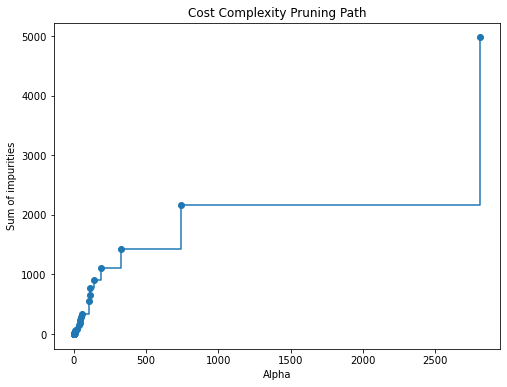

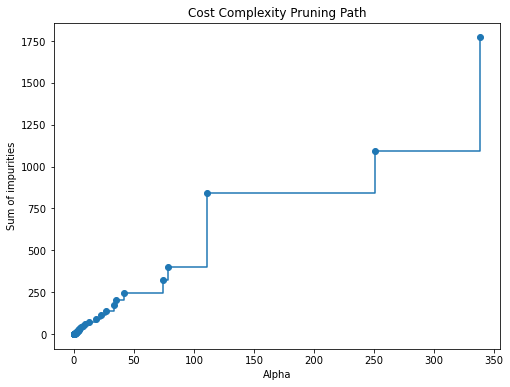

In [38]:
def cost_prun(X_train,y_train,model):
    ccp_path = model.cost_complexity_pruning_path(X_train,y_train)
    ccp_alphas = ccp_path.ccp_alphas
    impurities = ccp_path.impurities

    # Plotting the ccp_alpha vs. impurities
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
    ax.set_xlabel("Alpha")
    ax.set_ylabel("Sum of impurities")
    ax.set_title("Cost Complexity Pruning Path")

    # Show the plot
    plt.show()
# ES
cost_prun(es_X_train,es_y_train,model_es_dt)
# VC
cost_prun(vc_X_train,vc_y_train,model_vc_dt)

In [39]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

def DT_alpha(X_train,X_test,y_train, y_test,ccp_alpha):
    # Model fitting
    model = DecisionTreeRegressor(criterion='squared_error',
                                  splitter='best', 
                                  max_depth=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  random_state=42,
                                  max_leaf_nodes=None,
                                  ccp_alpha=ccp_alpha).fit(X_train, y_train)
    # print the depth of the decision tree.
    print(model.get_depth())
    # print the number of leaves of the decision tree
    print(model.get_n_leaves())
    
    # Plot the decision path
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_tree(model, feature_names=model.feature_names_in_)
    # Show the plot
    plt.show()

    # Generate forecasts in training part
    y_pred_train = model.predict(X_train)
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(X_test)
    return y_pred_train, y_pred_test

2
3


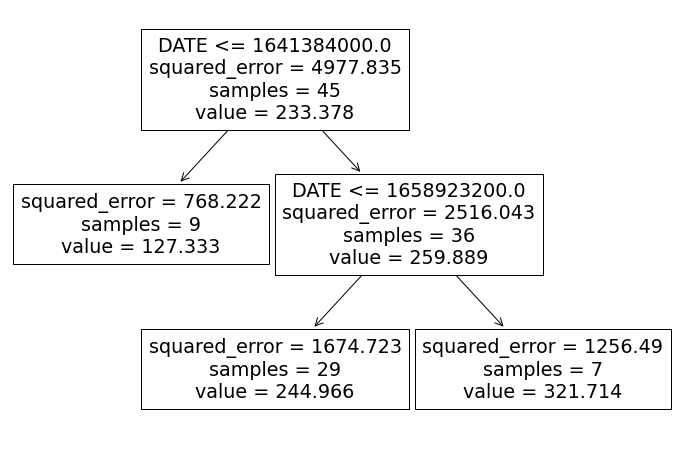

Residual : 64276.394
Residual : 94340.918
------- ES Train DT
MdAE: 24.966
MAE: 28.942
sMdAPE: 10.825 %
sMAPE: 13.357 %
RelMdAE: 0.559
RelMAE: 0.515
R-squared: 0.713

------- ES Test DT
MdAE: 38.000
MAE: 48.850
sMdAPE: 11.806 %
sMAPE: 17.393 %
RelMdAE: 0.429
RelMAE: 0.560
R-squared: 0.481


In [40]:
# ES
es_dt_train_500, es_dt_test_500 = DT_alpha(es_X_train, es_X_test, es_y_train, es_y_test,500)
# RSS of training part
RSS(es_y_train,es_dt_train_500)
# RSS of testing part
RSS(es_y_test,es_dt_test_500)
print('------- ES Train DT')
error_measure(es_y_train,es_dt_train_500,es_bm_train)
r_squared(es_y_train,es_dt_train_500,es_y_train)
print('\n------- ES Test DT')
error_measure(es_y_test,es_dt_test_500,es_bm_test)
r_squared(es_y_test,es_dt_test_500,es_y_train)

2
3


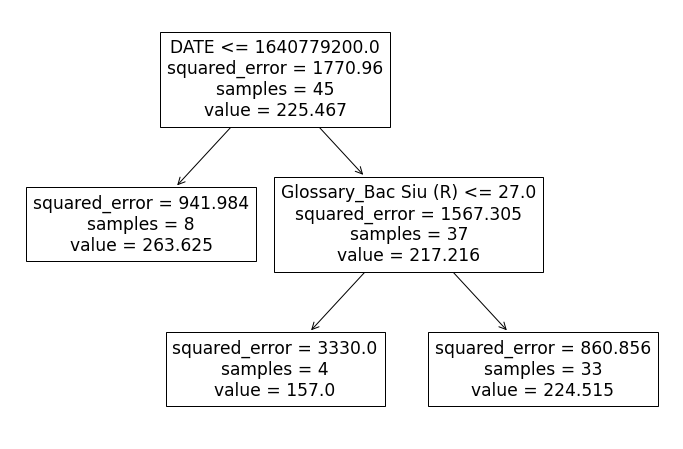

Residual : 49264.117
Residual : 76088.247

------- VC Train DT
MdAE: 20.485
MAE: 25.294
sMdAPE: 8.726 %
sMAPE: 12.076 %
RelMdAE: 1.049
RelMAE: 0.859
R-squared: 0.382

------- VC Test DT
MdAE: 41.500
MAE: 47.802
sMdAPE: 18.377 %
sMAPE: 24.700 %
RelMdAE: 1.000
RelMAE: 0.998
R-squared: 0.006


In [41]:
# VC
vc_dt_train_300, vc_dt_test_300 = DT_alpha(vc_X_train, vc_X_test, vc_y_train, vc_y_test,300)
# RSS of training part
RSS(vc_y_train,vc_dt_train_300)
# RSS of testing part
RSS(vc_y_test,vc_dt_test_300)
print('\n------- VC Train DT')
error_measure(vc_y_train,vc_dt_train_300,vc_bm_train)
r_squared(vc_y_train,vc_dt_train_300,vc_y_train)
print('\n------- VC Test DT')
error_measure(vc_y_test,vc_dt_test_300,vc_bm_test)
r_squared(vc_y_test,vc_dt_test_300,vc_y_train)

## 8. RF

### 8.1. Origin

In [42]:
# ES
model_es_rf, es_rf_train, es_rf_test = RF(es_X_train, es_X_test, es_y_train, es_y_test)
# VC
model_vc_rf, vc_rf_train, vc_rf_test = RF(vc_X_train, vc_X_test, vc_y_train, vc_y_test)

In [43]:
print('------- ES Train RF')
error_measure(es_y_train,es_rf_train,es_bm_train)
r_squared(es_y_train,es_rf_train,es_y_train)
print('\n------- ES Test RF')
error_measure(es_y_test,es_rf_test,es_bm_test)
r_squared(es_y_test,es_rf_test,es_y_train)
print('\n------- VC Train RF')
error_measure(vc_y_train,vc_rf_train,vc_bm_train)
r_squared(vc_y_train,vc_rf_train,vc_y_train)
print('\n------- VC Test RF')
error_measure(vc_y_test,vc_rf_test,vc_bm_test)
r_squared(vc_y_test,vc_rf_test,vc_y_train)

------- ES Train RF
MdAE: 10.660
MAE: 13.155
sMdAPE: 4.846 %
sMAPE: 6.349 %
RelMdAE: 0.239
RelMAE: 0.234
R-squared: 0.945

------- ES Test RF
MdAE: 36.345
MAE: 56.751
sMdAPE: 12.065 %
sMAPE: 20.007 %
RelMdAE: 0.410
RelMAE: 0.650
R-squared: 0.436

------- VC Train RF
MdAE: 9.160
MAE: 11.740
sMdAPE: 4.074 %
sMAPE: 5.891 %
RelMdAE: 0.469
RelMAE: 0.399
R-squared: 0.868

------- VC Test RF
MdAE: 46.070
MAE: 50.206
sMdAPE: 21.879 %
sMAPE: 25.739 %
RelMdAE: 1.110
RelMAE: 1.048
R-squared: -0.089


### 8.2. Improvement

In [44]:
from sklearn.ensemble import RandomForestRegressor

def RF_alpha(X_train,X_test,y_train, y_test,ccp_alpha):
    # Model fitting
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  max_features=None,
                                  max_leaf_nodes=None,
                                  bootstrap=True,
                                  random_state=42,
                                  max_samples=None,
                                  ccp_alpha=ccp_alpha).fit(X_train, y_train)

    # Generate forecasts in training part
    y_pred_train = model.predict(X_train)
    
    # Generate forecasts in testing part
    y_pred_test = model.predict(X_test)
    return y_pred_train, y_pred_test

In [45]:
# ES
es_rf_train_500, es_rf_test_500 = RF_alpha(es_X_train, es_X_test, es_y_train, es_y_test,500)
print('------- ES Train DT')
error_measure(es_y_train,es_rf_train_500,es_bm_train)
r_squared(es_y_train,es_rf_train_500,es_y_train)
print('\n------- ES Test DT')
error_measure(es_y_test,es_rf_test_500,es_bm_test)
r_squared(es_y_test,es_rf_test_500,es_y_train)

------- ES Train DT
MdAE: 28.636
MAE: 28.541
sMdAPE: 11.280 %
sMAPE: 13.186 %
RelMdAE: 0.642
RelMAE: 0.508
R-squared: 0.767

------- ES Test DT
MdAE: 39.959
MAE: 52.527
sMdAPE: 12.533 %
sMAPE: 18.676 %
RelMdAE: 0.451
RelMAE: 0.602
R-squared: 0.527


In [46]:
# VC
vc_rf_train_300, vc_rf_test_300 = RF_alpha(vc_X_train, vc_X_test, vc_y_train, vc_y_test,300)
print('\n------- VC Train DT')
error_measure(vc_y_train,vc_rf_train_300,vc_bm_train)
r_squared(vc_y_train,vc_rf_train_300,vc_y_train)
print('\n------- VC Test DT')
error_measure(vc_y_test,vc_rf_test_300,vc_bm_test)
r_squared(vc_y_test,vc_rf_test_300,vc_y_train)


------- VC Train DT
MdAE: 18.559
MAE: 24.335
sMdAPE: 7.873 %
sMAPE: 11.514 %
RelMdAE: 0.950
RelMAE: 0.827
R-squared: 0.460

------- VC Test DT
MdAE: 42.774
MAE: 48.395
sMdAPE: 19.843 %
sMAPE: 24.957 %
RelMdAE: 1.031
RelMAE: 1.010
R-squared: -0.016


## 9. Combine (SES + ARIMA + DT)

In [57]:
combine_y_train = (es_ses_train 
                   + es_arima_train1
                   + es_ls_train
                   + es_mlr_train2
                   + es_dt_train_500
                   + es_rf_train_500
                  )/6
combine_y_test = (es_ses_test
                  + es_arima_test1
                  + es_ls_test
                  + es_mlr_test2
                  + es_dt_test_500
                  + es_rf_test_500
                 )/6

In [58]:
print('------- ES Train Combine')
error_measure(es_y_train,combine_y_train,es_bm_train)
print('\n------- ES Test Combine')
error_measure(es_y_test,combine_y_test,es_bm_test)

------- ES Train Combine
MdAE: 25.957
MAE: 30.684
sMdAPE: 12.573 %
sMAPE: 14.252 %
RelMdAE: 0.582
RelMAE: 0.546

------- ES Test Combine
MdAE: 36.527
MAE: 55.575
sMdAPE: 11.544 %
sMAPE: 19.298 %
RelMdAE: 0.412
RelMAE: 0.637


## 10. Visualization

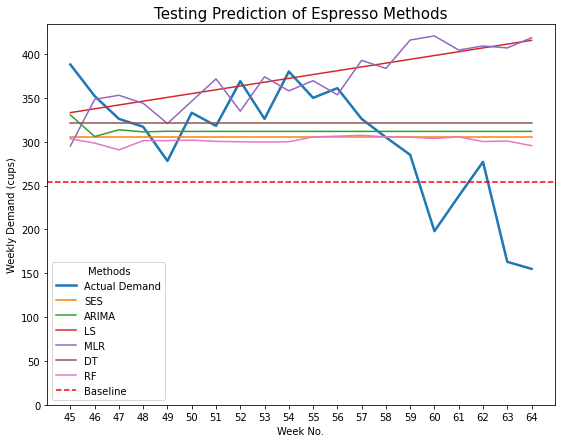

In [91]:
# Plot actual vs predicted demand in the training part
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(es_X_test.index, es_y_test, label='Actual Demand', linewidth=2.5)
#plt.plot(X_test.index, y_test, label='Testing Demand')
plt.plot(es_y_test.index, es_ses_test, label='SES')
plt.plot(es_y_test.index, es_arima_test1, label='ARIMA')
plt.plot(es_y_test.index, es_ls_test, label='LS')
plt.plot(es_y_test.index, es_mlr_test2, label='MLR')
plt.plot(es_y_test.index, es_dt_test_500, label='DT')
plt.plot(es_y_test.index, es_rf_test_500, label='RF')
plt.axhline(y=week_es['Weekly Demand'].mean(), color='red', linestyle='--', label='Baseline')
plt.ylim(bottom=0)
plt.xticks(es_X_test.index, es_X_test.index.astype(int))
plt.xlabel('Week No.')
plt.ylabel('Weekly Demand (cups)')
plt.title('Testing Prediction of Espresso Methods', fontsize = 15)
plt.legend(title='Methods',mode=None)
plt.show()

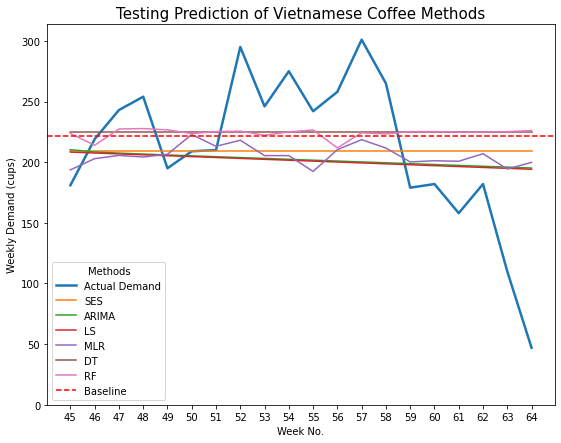

In [94]:
# Plot actual vs predicted demand in the training part
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(vc_X_test.index, vc_y_test, label='Actual Demand', linewidth=2.5)
#plt.plot(X_test.index, y_test, label='Testing Demand')
plt.plot(vc_y_test.index, vc_ses_test, label='SES')
plt.plot(vc_y_test.index, vc_arima_test, label='ARIMA')
plt.plot(vc_y_test.index, vc_ls_test, label='LS')
plt.plot(vc_y_test.index, vc_mlr_test, label='MLR')
plt.plot(vc_y_test.index, vc_dt_test_300, label='DT')
plt.plot(vc_y_test.index, vc_rf_test_300, label='RF')
plt.axhline(y=week_vc['Weekly Demand'].mean(), color='red', linestyle='--', label='Baseline')
plt.ylim(bottom=0)
plt.xticks(vc_X_test.index, vc_X_test.index.astype(int))
plt.xlabel('Week No.')
plt.ylabel('Weekly Demand (cups)')
plt.title('Testing Prediction of Vietnamese Coffee Methods', fontsize = 15)
plt.legend(title='Methods',mode=None)
plt.show()